# Scalable Constrained Bayesian Optimization (SCBO)
 Scalable Constrained Bayesian Optimization (SCBO) [1] in a closed loop in BoTorch.
 
[1]: David Eriksson and Matthias Poloczek. Scalable constrained Bayesian optimization. In International Conference on Artificial Intelligence and Statistics, pages 730–738. PMLR, 2021.
(https://doi.org/10.48550/arxiv.2002.08526)

Since SCBO is essentially a constrained version of Trust Region Bayesian Optimization (TuRBO), this tutorial shares much of the same code as the TuRBO Tutorial (https://botorch.org/tutorials/turbo_1) with small modifications made to implement SCBO.

In [10]:
import math
import os
import warnings
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch import Tensor
from torch.quasirandom import SobolEngine

from botorch.fit import fit_gpytorch_mll
# Constrained Max Posterior Sampling s a new sampling class, similar to MaxPosteriorSampling,
# which implements the constrained version of Thompson Sampling described in [1].
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.test_functions import Ackley, Rosenbrock, Levy
from botorch.utils.transforms import unnormalize
from botorch.test_functions import SyntheticTestFunction
from botorch.test_functions.base import BaseTestProblem, ConstrainedBaseTestProblem
from typing import List, Optional, Tuple, Union

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Simple quadratic problem with known constraints

In [11]:
# Here we define the example 10D Ackley function
fun = Ackley(dim=2, negate=True).to(**tkwargs)
fun.bounds[0, :].fill_(0.)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 1
n_init = 160
max_cholesky_size = float("inf")  # Always use Cholesky

# When evaluating the function, we must first unnormalize the inputs since
# we will use normalized inputs x in the main optimizaiton loop
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

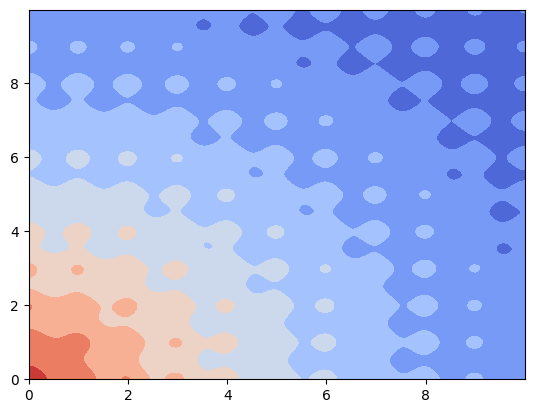

In [12]:
xs, ys = np.arange(0, 10, 1e-2), np.arange(0,10, 1e-2)
X, Y = np.meshgrid(xs, ys)
Z = fun(torch.tensor([np.ravel(X),np.ravel(Y)]).T).reshape(X.shape)

fig, ax = plt.subplots()
surf = ax.contourf(X, Y, Z, cmap=plt.cm.coolwarm)
plt.show()

### Defining two simple constraint functions

#### We'll use two constraints functions: c1 and c2 
We want to find solutions which maximize the above Ackley objective subject to the constraint that 
c1(x) <= 0 and c2(x) <= 0 
Note that SCBO expects all constraints to be of the for c(x) <= 0, so any other desired constraints must be modified to fit this form. 

Note also that while the below constraints are very simple functions, the point of this tutorial is to show how to use SCBO, and this same implementation could be applied in the same way if c1, c2 were actually complex black-box functions. 


In [141]:
def c1_known(x):   # x * y <= 4.
    return x[0]*x[1] - 4.

def c2_known(x):  # Equivalent to enforcing that ||x||_2 <= 5
    return x[1] - 2.


# We assume c1, c2 have same bounds as the Ackley function above
def eval_c1_known(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c1_known(unnormalize(x, fun.bounds))


def eval_c2_known(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c2_known(unnormalize(x, fun.bounds))


known_constraints = [c1_known, c2_known]
eval_known_constraints = [eval_c1_known, eval_c2_known]

In [147]:
def c3_unknown(x):  
    return x[0]**2 / 4 - x[0]**3 / 5

# We assume c1, c2 have same bounds as the Ackley function above
def eval_c3_unknown(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c3_unknown(unnormalize(x, fun.bounds))


unknown_constraints = [eval_c3_unknown]

In [148]:
import os
import sys
print(os.getcwd())
one_level_up_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(one_level_up_dir)
print(os.getcwd())

/Users/david.leeftink/Vscode_repositories/torchcontrol/bayesopt/notebooks
/Users/david.leeftink/Vscode_repositories/torchcontrol/bayesopt/notebooks


In [149]:
# from SCBO import ScboState

from SCBO import *

# Define example state
state = ScboState(dim=dim, batch_size=batch_size)
print(state)

ScboState(dim=2, batch_size=1, length=0.4, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=4, success_counter=0, success_tolerance=5, best_value=-inf, best_constraint_values=tensor([inf, inf], dtype=torch.float64), restart_triggered=False)


### Generate Initial Points

Here we define a simple method to generate a set of random initial datapoints that we will use to kick-off optimization. 

In [150]:
def get_initial_points(dim, n_pts, seed=10):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    accepted_samples = []
    while len(accepted_samples)<n_pts:
        X_init = sobol.draw(n=1).to(dtype=dtype, device=device)
        feasibles = np.array([c(X_init[0])<=0. for c in eval_known_constraints])
        feasible = feasibles.sum() == feasibles.shape[0]
        if feasible:
            accepted_samples.append(X_init)
    return accepted_samples

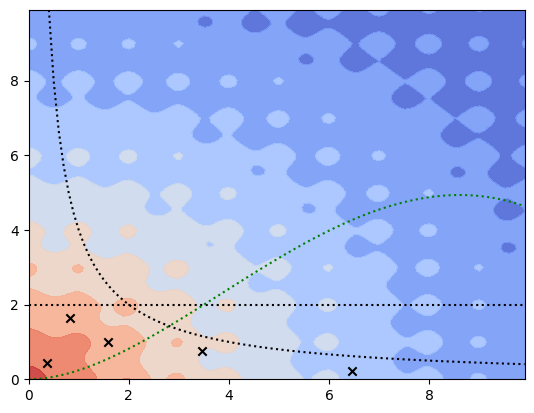

In [172]:
list_output = get_initial_points(dim=2, n_pts=5)
X_init = torch.cat(list_output, dim=0)
X_init = unnormalize(X_init, fun.bounds)
xs, ys = np.arange(0, 10, 1e-1), np.arange(0,10, 1e-1)
X, Y = np.meshgrid(xs, ys)
Z = fun(torch.tensor([np.ravel(X),np.ravel(Y)]).T).reshape(X.shape)

fig, ax = plt.subplots(1,1)
surf = ax.contourf(X, Y, Z, cmap=plt.cm.coolwarm, alpha=0.9)
# ax.axhline(y=3., linestyle=':', color='black')

# c1_region = lambda x: 2./x
# region_vals = c1_region(xs[1:])

# ax.plot(xs[1:], region_vals, color='black', linestyle=':')
ax.set_xlim((0., 9.9))
ax.set_ylim((0., 9.9))
for i in range(len(X_init)):
    ax.scatter(X_init[i,0], X_init[i,1], marker='x', color='black')

    # print(f'{i+1} - X:{X_init[i]}, Y:{fun(X_init[i,0], X_init[i,1])}, c1: {c1(X_init[i])}, c2: {c2(X_init[i])}')

# y = x - 0.1
# plt.plot([-0.1,])
    # return x[0] - x[1] + 0.1
ax.axhline(y=2., linestyle=':', color='black')
ax.plot(xs, 4/xs, linestyle=':', color='black')# x * y <= 4.
ax.plot(xs, (xs**2/3) - (xs**2.5 / 11), linestyle=':', color='green')




### Generating a batch of candidates for SCBO 

Just as in the TuRBO Tutorial (https://botorch.org/tutorials/turbo_1), we'll define a method generate_batch to generate a new batch of candidate points within the TuRBO trust region using Thompson sampling. 

The key difference here from TuRBO is that, instead of using MaxPosteriorSampling to simply grab the candidates within the trust region with the maximum posterior values, we use ConstrainedMaxPosteriorSampling to instead grab the candidates within the trust region with the maximum posterior values subject to the constraint that the posteriors for the constraint models for c1(x) and c2(x) must be less than or equal to 0 for both candidates. 

We use additional GPs ('constraint models') to model each black-box constraint (c1 and c2), and throw out all candidates for which the sampled value for these constraint models is greater than 0. According to [1], in the special case when all of the candidaates are predicted to be constraint violators, we select the candidate with the minimum predicted violation. (See botorch.generation.sampling.ConstrainedMaxPosteriorSampling for implementation details).

In [ ]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    C,  # Constraint values
    batch_size,
    n_candidates,  # Number of candidates for Thompson sampling
    constraint_model,
    sobol: SobolEngine,
):
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    # Create the TR bounds
    best_ind = get_best_index_for_batch(Y=Y, C=C)
    x_center = X[best_ind, :].clone()
    tr_lb = torch.clamp(x_center - state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + state.length / 2.0, 0.0, 1.0)

    # Thompson Sampling w/ Constraints (SCBO)
    dim = X.shape[-1]
    pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / dim, 1.0)
    mask = torch.rand(n_candidates, dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = x_center.expand(n_candidates, dim).clone()
    X_cand[mask] = pert[mask]

    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=model, constraint_model=constraint_model, replacement=False
    )
    with torch.no_grad():
        X_next = constrained_thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

## Main Optimization Loop

In [ ]:
# Generate initial data
torch.set_printoptions(sci_mode=False)
train_X = get_initial_points(dim, n_init)
print(train_X)
assert 1==2, ""

# good_starter = torch.Tensor([[0.3111, 0.3134, 0.3244, 0.3441, 0.3747, 0.2913, 0.3257, 0.3519, 0.3213, 0.3261]])
# train_X = torch.cat((train_X, good_starter))
train_Y = torch.tensor([eval_objective(x) for x in train_X], **tkwargs).unsqueeze(-1)


C3 = torch.tensor([eval_c3_unknown(x) for x in train_X], **tkwargs).unsqueeze(-1)

obs_std = 0.0

# Initialize TuRBO state
state = ScboState(dim, batch_size=batch_size)

# Note: We use 2000 candidates here to make the tutorial run faster.
# SCBO actually uses min(5000, max(2000, 200 * dim)) candidate points by default.
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
sobol = SobolEngine(dim, scramble=True, seed=1)


def get_fitted_model(X, Y):
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-4, 5e-1))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(
        X,
        Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        fit_gpytorch_mll(mll)
    return model

torch.manual_seed(1)

all_scores = []
while not state.restart_triggered:  # Run until TuRBO converges
    
    # Fit GP models for objective and constraints
    model = get_fitted_model(train_X, train_Y)

    c3_model = get_fitted_model(train_X, C3)

    # Generate a batch of candidates
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        X_next = generate_batch(
            state=state,
            model=model,
            X=train_X,
            Y=train_Y,
            C=torch.cat((C1, C2), dim=-1),
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            constraint_model=ModelListGP(c3_model,),
            sobol=sobol,
        )

    # Evaluate both the objective and constraints for the selected candidaates

    Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
    Y_next += torch.randn(size=Y_next.shape) * obs_std

    C_next = torch.tensor([eval_c3_unknown(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
    # C_next = torch.cat([C1_next, C2_next], dim=-1)

    # Update TuRBO state
    state = update_state(state=state, Y_next=Y_next, C_next=C_next)

    # Append data. Note that we append all data, even points that violate
    # the constraints. This is so our constraint models can learn more
    # about the constraint functions and gain confidence in where violations occur.
    train_X = torch.cat((train_X, X_next), dim=0)
    train_Y = torch.cat((train_Y, Y_next), dim=0)
    C1 = torch.cat((C1, C1_next), dim=0)
    C2 = torch.cat((C2, C2_next), dim=0)

    # Print current status. Note that state.best_value is always the best
    # objective value found so far which meets the constraints, or in the case
    # that no points have been found yet which meet the constraints, it is the
    # objective value of the point with the minimum constraint violation.
    if (state.best_constraint_values <= 0).all():
        print(f"{len(train_X)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")
        # best_Y_idx = torch.argmax(train_Y)
        # best_X = train_X[best_Y_idx]
        # print(f'best solution so far X: ', {best_X}, '   score: ', torch.max(train_Y))
    else:
        violation = state.best_constraint_values.clamp(min=0).sum()
        print(
            f"{len(train_X)}) No feasible point yet! Smallest total violation: "
            f"{violation:.2e}, TR length: {state.length:.2e}"
        )

### Plot Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))

score = train_Y.clone()
# Set infeasible to -inf
score[~(torch.cat((C1, C2), dim=-1) <= 0).all(dim=-1)] = float("-inf")
fx = np.maximum.accumulate(score.cpu())
plt.plot(fx, marker="", lw=3)

plt.plot([0, len(train_Y)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.ylabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley with 2 outcome constraints", fontsize=20)
plt.xlim([0, len(train_Y)])
plt.ylim([-15, 1])

plt.grid(True)
plt.show()

In [ ]:
# %matplotlib notebook
def plot(i):
    best_idx = train_Y.argmax()
    best_X = unnormalize(train_X[best_idx], fun.bounds)
    print(f'best X: ', best_X)
    print(f'c1: ', c1(best_X))
    print(f'c2: ', c2(best_X))

    xs, ys = np.arange(-10, 10, 1e-1), np.arange(-10,10, 1e-1)
    X, Y = np.meshgrid(xs, ys)
    Z = fun(torch.tensor([np.ravel(X),np.ravel(Y)]).T).reshape(X.shape)

    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, alpha=0.4)
    Z_plane = np.zeros(X.shape) - 15 + 15*(X-Y> 0.)
    # ax.plot_surface(X, Y, Z_plane, color='green', alpha=0.3)
    ax.view_init(60, 80)

    unnormalized_train_X = unnormalize(train_X, bounds=fun.bounds)
    return ax
for i in range(8, len(train_X)):
    ax = plot(i)
    for j in range(0, i):
        ax.scatter(unnormalized_train_X[j,0], unnormalized_train_X[j,1],train_Y[j], marker='x', color=plt.cm.plasma(j/len(train_X)))

    plt.show()
ax.scatter(best_X[0], best_X[1], train_Y[best_idx], marker='x', color='black')
plt.show()

In [ ]:
c1_model(train_X[best_idx][None])